In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from keras import layers, models
from keras import *
from sklearn.utils.class_weight import compute_class_weight

2024-06-13 13:41:41.834578: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-13 13:41:41.971800: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class_colors = [
    (0, 0, 0),
    (180, 120, 120),  # building non-flooded --
    (140, 140, 140),   # road-non-flooded
    (61, 230, 250),    # water --
    (0, 82, 255),      # tree
    (255, 0, 245),     # vehicle
    (255, 235, 0), # pool
    (4, 250, 7)        # grass
]

# class_colors = [
#     (0, 0, 0),
#     (140, 140, 140),   # road-non-flooded
#     (4, 250, 7) ,       # grass
#     (61, 230, 250),    # water
#     (0, 82, 255)      # tree
# ]


def encoder(input_tensor, filters, use_bn=True, use_activation=True):
    x = layers.Conv2D(filters, kernel_size=2, strides=2, padding='same')(input_tensor)
    if use_bn:
        x = layers.BatchNormalization()(x)
    if use_activation:
        x = layers.LeakyReLU(negative_slope=0.2)(x)
        #x = layers.Softmax(x) 

    return x

def decoder(input_tensor, skip_tensor, filters, dropout=False):
    x = layers.Conv2DTranspose(filters, kernel_size=2, strides=2, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    if dropout:
        x = layers.Dropout(0.2)(x)
    x = layers.ReLU()(x)
    result = layers.concatenate([x, skip_tensor], axis=3)
    return result

# Input_shape requirement as described in research paper
def UNet(input_shape=(256,256,3)):

    inputs = layers.Input(shape=input_shape)

    # Encoder Block
    conv1 = encoder(inputs, 64, use_bn=False, use_activation=False)
    conv2 = encoder(conv1, 128)
    conv3 = encoder(conv2, 256)
    conv4 = encoder(conv3, 512)
    # conv5 = encoder(conv4, 512)
    # conv6 = encoder(conv5, 512)
    conv7 = encoder(conv4, 512)

    # Latent Space Representation 
    # (bottleneck layer)
    bn = encoder(conv7, 512)
    
    # Decoder Block
    deconv1 = decoder(bn, conv7, 512, dropout=True) 
    # deconv2 = decoder(deconv1, conv6, 512, dropout=True)
    # deconv3 = decoder(deconv2, conv5, 512, dropout=True)
    deconv4 = decoder(deconv1, conv4, 512)
    deconv5 = decoder(deconv4, conv3, 256)
    deconv6 = decoder(deconv5, conv2, 128)
    deconv7 = decoder(deconv6, conv1, 64)
    
    output = layers.Conv2DTranspose(len(class_colors), kernel_size=4, strides=2, padding='same', activation='softmax')(deconv7)
    print(output.shape)

    seg_model = models.Model(inputs=inputs, outputs=output)
    return seg_model

def load_images():
    train_imgs_real = '/home/anirud/Desktop/SemanticSeg/train-org-img'
    train_imgs_lab = '/home/anirud/Desktop/SemanticSeg/ColorMasks-TrainSet'
    val_imgs_real = '/home/anirud/Desktop/SemanticSeg/val-org-img'
    val_imgs_lab = '/home/anirud/Desktop/SemanticSeg/ColorMasks-ValSet'
    test_imgs_real = '/home/anirud/Desktop/SemanticSeg/test-org-img'
    test_imgs_label = '/home/anirud/Desktop/SemanticSeg/ColorMasks-TestSet'

    train_imgs_actual = []
    train_imgs_label = []
    val_imgs_actual = []
    val_imgs_label = []
    img_size = (256,256)

    # Actual Training Images
    for filename in os.listdir(train_imgs_real):
        path = os.path.join(train_imgs_real, filename)
        img = cv2.imread(path)
        img = cv2.resize(img, img_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0
        train_imgs_actual.append(img)

    # Training Labeled Images
    for filename in os.listdir(train_imgs_lab):
        path = os.path.join(train_imgs_lab, filename)
        og_img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        seg_img = cv2.resize(og_img, img_size)
        seg_img = cv2.cvtColor(seg_img, cv2.COLOR_BGR2RGB)
        # train_imgs_label.append(seg_img)

        seg_one_hot = np.zeros((256, 256, len(class_colors)), dtype=np.uint8)

        for index, color in enumerate(class_colors):
            seg_one_hot[:, :, index] = np.all(seg_img == color, axis=-1).astype(np.uint8)

        train_imgs_label.append(seg_one_hot)

    # Actual Validation Images
    for filename in os.listdir(val_imgs_real):
        path = os.path.join(val_imgs_real, filename)
        img = cv2.imread(path)
        img = cv2.resize(img, img_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0
        val_imgs_actual.append(img)

    # Validation Labeled Images
    for filename in os.listdir(val_imgs_lab):
        path = os.path.join(val_imgs_lab, filename)
        og_img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        seg_img = cv2.resize(og_img, img_size)
        seg_img = cv2.cvtColor(seg_img, cv2.COLOR_BGR2RGB)
        #val_imgs_label.append(seg_img)

        seg_one_hot = np.zeros((256, 256, len(class_colors)), dtype=np.uint8)

        for index, color in enumerate(class_colors):
            seg_one_hot[:, :, index] = np.all(seg_img == color, axis=-1).astype(np.uint8)

        val_imgs_label.append(seg_one_hot)

    return (np.array(train_imgs_actual), np.array(train_imgs_label), np.array(val_imgs_actual), np.array(val_imgs_label))

train_img, train_label, val_img, val_label = load_images()

In [2]:
img.shape

NameError: name 'img' is not defined

In [3]:
flat_labels = np.argmax(train_label, axis=-1).flatten()

weights = compute_class_weight('balanced', classes=np.unique(flat_labels), y=flat_labels)
weights_dict = {i: weight for i, weight in enumerate(weights)}

In [4]:
weights_dict

{0: 1.8037408291298451,
 1: 4.032098439903318,
 2: 2.3576266319426824,
 3: 1.1534935734265783,
 4: 0.7121384142667675,
 5: 77.66983058738876,
 6: 64.88770233117337,
 7: 0.2235140234340338}

In [4]:
weights_dict

{0: 3.978943007549946,
 1: 6.3985167798068,
 2: 3.1412001501945763,
 3: 3.537189798648092,
 4: 1.8438907811419056,
 5: 0.9246609396633709,
 6: 0.5813554970663806,
 7: 60.20657253116834,
 8: 50.80146557874804,
 9: 0.17821785830279807}

In [9]:
weights_dict

{0: 1.8037408291298451,
 1: 4.032098439903318,
 2: 2.3576266319426824,
 3: 1.1534935734265783,
 4: 0.7121384142667675,
 5: 77.66983058738876,
 6: 64.88770233117337,
 7: 0.2235140234340338}

In [5]:
print(train_label)

[[[[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  ...

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]]


 [[[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 1]
   [0 0 0 ... 0 0 1]
   [0 0 0 ... 0 0 1]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [

In [13]:
print(train_label)

[[[[255  82   0]
   [255  82   0]
   [255  82   0]
   ...
   [250 230  61]
   [250 230  61]
   [250 230  61]]

  [[255  82   0]
   [255  82   0]
   [255  82   0]
   ...
   [250 230  61]
   [250 230  61]
   [250 230  61]]

  [[255  82   0]
   [255  82   0]
   [255  82   0]
   ...
   [250 230  61]
   [250 230  61]
   [250 230  61]]

  ...

  [[250 230  61]
   [250 230  61]
   [250 230  61]
   ...
   [250 230  61]
   [250 230  61]
   [250 230  61]]

  [[250 230  61]
   [250 230  61]
   [250 230  61]
   ...
   [250 230  61]
   [250 230  61]
   [250 230  61]]

  [[250 230  61]
   [250 230  61]
   [250 230  61]
   ...
   [250 230  61]
   [250 230  61]
   [250 230  61]]]


 [[[255  82   0]
   [255  82   0]
   [255  82   0]
   ...
   [  7 250   4]
   [  7 250   4]
   [  7 250   4]]

  [[255  82   0]
   [255  82   0]
   [255  82   0]
   ...
   [  7 250   4]
   [  7 250   4]
   [  7 250   4]]

  [[255  82   0]
   [255  82   0]
   [255  82   0]
   ...
   [  7 250   4]
   [  7 250   4]
   [  7 250

In [24]:
#weights_array = np.zeros(len(class_colors))
weights_array = []
for index, w in weights_dict.items():
    weights_array.append(w)

In [8]:
train_labels.shape[0]

1445

In [ ]:
weights_dict

In [10]:
generator = UNet()
generator.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
print('Compiled Model')
train_labels = train_label
val_labels = val_label
generator.fit(train_img, train_labels, epochs=6, batch_size=32, validation_data=(val_img, val_labels))
generator.save_weights('upd_model_one.weights.h5')
# generator.summary()
print('Program done')

(None, 256, 256, 8)
Compiled Model
Epoch 1/6
56/56 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.4487 - loss: 1.4294 - val_accuracy: 0.5438 - val_loss: 1.3751
Epoch 2/6
56/56 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.5712 - loss: 1.1360 - val_accuracy: 0.5435 - val_loss: 1.2548
Epoch 3/6
56/56 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.5594 - loss: 1.1626 - val_accuracy: 0.5438 - val_loss: 1.2347
Epoch 4/6
56/56 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.5599 - loss: 1.1628 - val_accuracy: 0.5437 - val_loss: 1.2094
Epoch 5/6
56/56 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.5541 - loss: 1.1652 - val_accuracy: 0.5438 - val_loss: 1.1777
Epoch 6/6
56/56 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.5637 - loss: 1.1661 - val_accuracy: 0.5438 - val_loss: 1.1877
Program done


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Unique values:  [7]
(256, 256, 3)


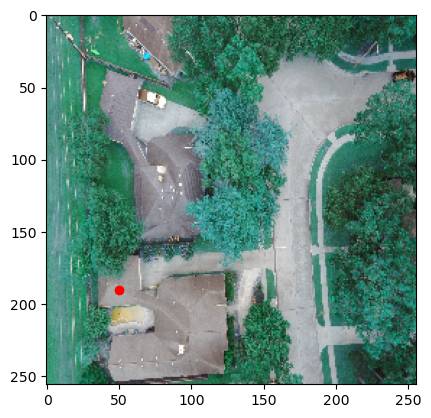

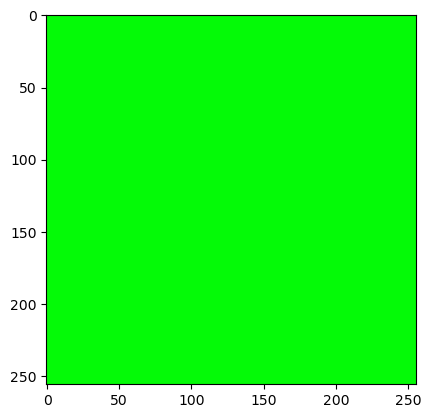

In [11]:
def decode_segmap(seg_map, class_colors=class_colors):
    h, w = seg_map.shape[:2]
    seg_img = np.zeros((h, w, 3), dtype=np.uint8)

    for i, color in enumerate(class_colors):
        mask = seg_map == i
        seg_img[mask] = color

    return seg_img

def predict_visualize(img, model, predicted_img=None):
    img = cv2.resize(img, (256,256))
    img = np.expand_dims(img / 255.0, axis=0)

    predicted_val = model.predict(img)[0]
    predicted_img = predicted_val
    predicted_labs = np.argmax(predicted_val, axis=-1)
    print('Unique values: ', np.unique(predicted_labs))
    class_dict = {0: 'background', 1: 'building-flooded', 2: 'building-non-flooded', 
                3: 'road-flooded', 4: 'road-non-flooded', 5: 'water', 6: 'tree',
                7: 'vehicle', 8: 'pool', 9: 'grass'}
    seg_img = decode_segmap(predicted_labs)
    print(seg_img.shape)
    
    #fig, (ax1, ax2) = plt.subplots(1,2)
   # #ax1.imshow(cv2.resize(img[0], (3000, 4000)))
    #ax2.imshow(cv2.resize(seg_img, (4000,3000)))
   # plt.imshow(cv2.resize(img[0], (4000,3000)))
    plt.imshow(img[0])
    plt.plot(50, 190,'ro')
    plt.show()
    plt.imshow(seg_img)
   # plt.imshow(cv2.resize(seg_img, (4000,3000)))
    plt.show()

    return seg_img, predicted_img

    # plt.imshow(seg_img)
    # plt.show()
    

#print(image.shape)
image = cv2.imread('/home/anirud/Desktop/SemanticSeg/test-org-img/10814.jpg')
labeled_image = cv2.resize(cv2.imread('/home/anirud/Desktop/SemanticSeg/ColorMasks-TestSet/10814_lab.png'), (256,256))
labeled_image = cv2.cvtColor(labeled_image, cv2.COLOR_BGR2RGB)
result, prediction = predict_visualize(image, generator)

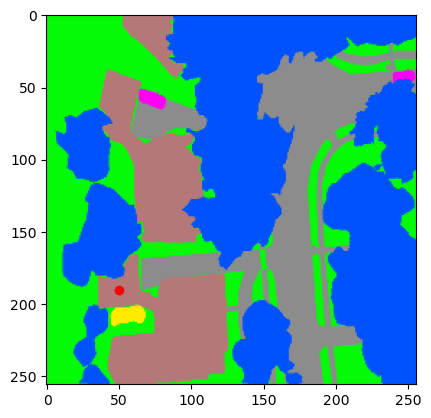

In [124]:
plt.imshow(labeled_image)
plt.plot(50,190,'ro')

In [12]:
print('probs: ', prediction[50, 190])
print('actual: ', labeled_image[50, 190])
test = np.argmax(prediction, axis=-1)
test[50, 190]

probs:  [2.8888494e-02 3.2917518e-02 3.5422742e-02 9.2179403e-02 1.8254603e-01
 5.5209275e-06 4.2170075e-05 6.2799811e-01]
actual:  [140 140 140]


7

In [126]:
print('probs: ', prediction[50, 190])
print('actual: ', labeled_image[50, 190])
test = np.argmax(prediction, axis=-1)
test[50, 190]

probs:  [0.02718736 0.05075804 0.06863248 0.16525756 0.17724727 0.01136184
 0.0156562  0.48389918]
actual:  [140 140 140]


7

In [5]:
print('probs: ', prediction[50, 190])
print('actual: ', labeled_image[50, 190])
test = np.argmax(prediction, axis=-1)
test[50, 190]

probs:  [0.02047072 0.05810924 0.08233026 0.17294061 0.15900864 0.01128402
 0.01357281 0.48228368]
actual:  [140 140 140]


7

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Unique values:  [0 1 2 3 4 5 6]
(256, 256, 3)


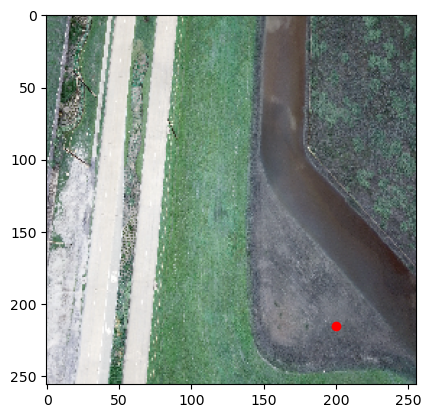

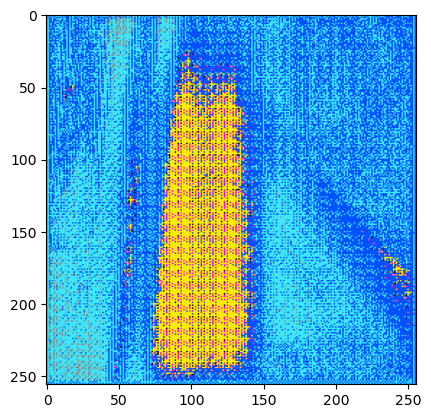

(array([[[180, 120, 120],
         [  0,  82, 255],
         [180, 120, 120],
         ...,
         [  0,  82, 255],
         [ 61, 230, 250],
         [  0,   0,   0]],
 
        [[  0,  82, 255],
         [ 61, 230, 250],
         [  0,  82, 255],
         ...,
         [  0,  82, 255],
         [ 61, 230, 250],
         [  0,  82, 255]],
 
        [[140, 140, 140],
         [  0,  82, 255],
         [140, 140, 140],
         ...,
         [  0,  82, 255],
         [ 61, 230, 250],
         [  0,  82, 255]],
 
        ...,
 
        [[  0,  82, 255],
         [ 61, 230, 250],
         [ 61, 230, 250],
         ...,
         [  0,  82, 255],
         [ 61, 230, 250],
         [  0,  82, 255]],
 
        [[  0,  82, 255],
         [ 61, 230, 250],
         [  0,  82, 255],
         ...,
         [  0,  82, 255],
         [ 61, 230, 250],
         [  0,  82, 255]],
 
        [[ 61, 230, 250],
         [  0,  82, 255],
         [ 61, 230, 250],
         ...,
         [  0,  82, 255],
  

In [58]:
image = cv2.imread('/home/anirud/Desktop/SemanticSeg/test-org-img/6342.jpg')
predict_visualize(image, generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Unique values:  [1 2 3 4 5 6 7 8]
(256, 256, 3)


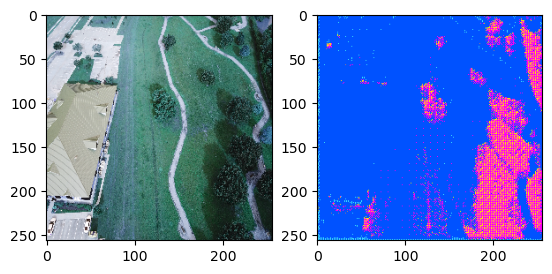

In [12]:
image = cv2.imread('/home/anirud/Desktop/SemanticSeg/test-org-img/8447.jpg')
predict_visualize(image, generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Unique values:  [1 2 3 4 5 6 7 8]
(256, 256, 3)


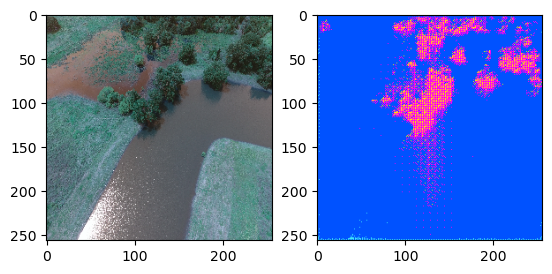

In [16]:
image = cv2.imread('/home/anirud/Desktop/SemanticSeg/train-org-img/11723.jpg')
predict_visualize(image, generator)